#  <center> Problem Set 6 <center>

<center> 3.C01/3.C51, 10.C01/10.C51 <center>

In [2]:
# Cheminformatics
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors,Crippen
from rdkit import RDLogger
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
RDLogger.DisableLog('rdApp.*')

# Arrays
import numpy as np
import pandas as pd

# Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

# Statsmodels
import statsmodels.formula.api as sm

# Plotting 
import matplotlib.pyplot as plt
import matplotlib as mpl

# Personal utility package
import package.plot
from package.plot import get_size_inches
from pathlib import Path

# Machine learning
import torch
from torchmetrics.regression import R2Score
from torcheval.metrics.functional import r2_score as r2
from lightning import pytorch as pl
from lightning.pytorch.loggers import CSVLogger

# 10.1021/acs.jcim.3c01250
from chemprop import data, featurizers, models, nn
from chemprop.data.collate import NamedTuple, BatchMolGraph, Tensor, Iterable, Datum, collate_batch
from chemprop.data.dataloader import MoleculeDataset, ReactionDataset, MulticomponentDataset, DataLoader

# Utility
from datetime import datetime
from dataclasses import dataclass

# XGBoost
from xgboost import XGBRegressor

# Hyperparamter tuning
import optuna
from optuna_integration.pytorch_lightning import PyTorchLightningPruningCallback


/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def write(name,values):
    # Append cross-validation results to results.csv for plotting.
    with open("results.csv", "a") as fhandle:
        fhandle.write(f"{name},{values}\n")

## Part 1: Baseline Regression Methods

### Part 1.1: (5 points) Prepare Dataset

In [9]:
data_dir = Path.cwd() / "data" # Folder for Solvation Free Energy datasets
train_file = data_dir / "solvation_train.csv" # Train set
test_file = data_dir / "solvation_test.csv" # Test set
prop_file = data_dir / "molecule_props.csv" # Molecule properties
df = pd.read_csv(train_file) # Load data
mol_prop = pd.read_csv(prop_file) # Read into a CSV

# We're not going to use molecule_props.csv. It looks like it's missing some SMILES strings,
# which leads to errors when I use them on the dataset.

Generate fingerprints (e.g. a Morgan fingerprint).

In [5]:
smiles = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C' # Random SMILES string
mol = Chem.MolFromSmiles(smiles) # Load SMILES into RDKit
fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=512) # Morgan fingerprint 
# During production, you should use nBits >= 1024 since it improves performance
# read https://jcheminf.biomedcentral.com/articles/10.1186/s13321-016-0148-0#Sec14
fp_array = np.zeros((1,), int) # convert to numpy array
DataStructs.ConvertToNumpyArray(fp, fp_array)

Generate various chemical properties.

In [6]:
MolWt = Descriptors.ExactMolWt(mol) # molecular weight
TPSA = Chem.rdMolDescriptors.CalcTPSA(mol) # Topological Polar Surface Area
nRotB = Descriptors.NumRotatableBonds(mol) # number of rotable bonds
HBD = Descriptors.NumHDonors(mol) # number of H bond donors
HBA = Descriptors.NumHAcceptors(mol) # number of H bond acceptors
logP = Descriptors.MolLogP(mol) # LogP
dct_pol = dict(zip(mol_prop["SMILES"],mol_prop["polarizability"]))
dct_dip = dict(zip(mol_prop["SMILES"],mol_prop["dipole"]))
# There are other RDKit descriptors like molecular refractivity, Labute accesible surface area,
# and Lipinski descriptors that could be useful for predicting solvation free energy.
# These descriptors take seconds to calculate and are only calculated once,
# so they should be added if they improve accuracy.
# Later on, we do a masking study to show that RDKit descriptors are important in exceeding
# the TA's benchmarks.

Create a feature set with concatenated physical descriptors.

In [6]:
# Define a featurizer class which can interact with Chemprop
# The rationale for including these various descriptors are described in the accompanying report.
@dataclass
class PropFeaturizer(featurizers.Featurizer):
    def __init__(self, features: list):
        # Initialize PropFeaturizer with a fixed set of features
        self.features = features

    def __len__(self) -> int:
        return len(self.features)

    def MolWt(self, mol):
        # Molecular weight
        return Descriptors.ExactMolWt(mol)

    def TPSA(self, mol):
        # Total polarizable surface area
        return Chem.rdMolDescriptors.CalcTPSA(mol)
    
    def LASA(self, mol):
        # Labute accessible surface area
        return Chem.rdMolDescriptors.CalcLabuteASA(mol)

    def NumRotatableBonds(self, mol):
        # Number of rotatable bonds
        return Descriptors.NumRotatableBonds(mol)

    def NumHDonors(self, mol):
        # Number of hydrogen bond donors
        return Descriptors.NumHDonors(mol)

    def NumHAcceptors(self, mol):
        # Number of hydrogen bond acceptors
        return Descriptors.NumHAcceptors(mol)

    def MolLogP(self, mol):
        # Wildman-Crippen octanol-water partition coefficient
        # https://pubs.acs.org/doi/10.1021/ci990307l
        return Descriptors.MolLogP(mol)

    def MolMR(self, mol):
        # Wildman-Crippin molar refractivity
        # https://pubs.acs.org/doi/10.1021/ci990307l
        return Descriptors.MolMR(mol)

    def AromProp(self, mol):
        # Custom defined function to calculate the number of aromatic atoms
        # among the heavy atoms. In hindsight, there's other descriptors in Chem.Lipinski
        # that could be useful for predicting solvation free energy. These descriptors
        # are used directly for Lipinski's rule of 5 in drug discovery, but SFE properties
        # and drug viability are closely tied.
        if mol.GetNumHeavyAtoms() > 0 :
            return len(list(mol.GetAromaticAtoms())) / mol.GetNumHeavyAtoms()
        else:
            return 0

    def __call__(self, mol: Chem.Mol) -> np.ndarray:
        # Return a numpy array of the various features defined in PropFeaturizer
        return np.array([getattr(self,feature)(mol) for feature in self.features])

In [10]:
# Why we choose these features is described in the accompanying report
# We use this feature list for PropFeaturizer
features = ["TPSA", "LASA", "NumRotatableBonds", "NumHDonors", "NumHAcceptors",
            "MolLogP", "MolMR", "AromProp"]

# Here, we define a featurizing function for fingerprints and concatenating that with
# the output from PropFeaturizer
def featurize(smiles):
    mol = Chem.MolFromSmiles(smiles) # load SMILES into RDKit
    fp = AllChem.GetMorganGenerator(radius=2, fpSize=1024) # Generate fingerprints >=1024 bits
    # 2048 is quite large and leads to kernels crashing when doing TSNE, so I'm using 1024.
    # This should be a hyperparameter to optimize for. 
    fp_array = np.array(fp.GetFingerprint(mol)) # Get fingerprints
    featurizer = PropFeaturizer(features) # Get feature array
    return np.hstack([fp_array, featurizer(mol)]) # Concatenate fingerprints with feature array
y = df["logK"] # Get output vector
X_solvent = np.stack(df["Solvent"].apply(featurize).values) # Get input vector for solvent
X_solute = np.stack(df["Solute"].apply(featurize).values) # Get input vector for solute
X = np.hstack([X_solvent,X_solute]) # Concatenate the input vectors into a solvent-solute matrix

### 1.2 (10 points) Linear Regression

Train a linear regression model and report a 5-fold cross-validated R^2.

In [11]:
# Will a simple linear regression model work?
scores = cross_val_score(LinearRegression(), X, y, cv = 5, scoring = "r2") 
print(f"No Regularization R2: {scores.mean()}")
write("linear",scores)
# Will L1 regularization help improve generalization?
scores = cross_val_score(Lasso(), X, y, cv = 5, scoring = "r2")
print(f"Lasso R2: {scores.mean()}")
write("lasso",scores)
# Will L2 regularization help improve generalization?
scores = cross_val_score(Ridge(), X, y, cv = 5, scoring = "r2")
print(f"Ridge R2: {scores.mean()}")
write("ridge",scores)

# We observe a negative R-squared from simple linear regression because fingerprints are sparse
# and high-dimensional, which leads to poor predictions under simple linear regression.
# L1 and L2 regularization improve the performance on the sparse dataset. Because the fingerprint
# bits are 0s and 1s, Lasso will force many coefficients to be equal to zero, which is undesirable.
# L2 regularization performs better because it instead makes many coefficients close to zero but
# non-zero, allowing the model to still differentiate between fingerprints.

No Regularization R2: -2.440844438552741e+18
Lasso R2: 0.7189205413929178
Ridge R2: 0.9369656008111671


I noticed that the R-squared I submitted in the report comes from not normalizing the dataset. Let's test using the standard scaler below:

In [12]:
scaler = StandardScaler() # Define a standard scaler from sklearn
# Will a simple linear regression model work?
pipe = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])
scores = cross_val_score(pipe, X, y, cv = 5, scoring = "r2") 
print(f"No Regularization R2: {scores.mean()}")
write("linear",scores)
# Will L1 regularization help improve generalization?
pipe = Pipeline([('scaler', StandardScaler()), ('model', Lasso())])
scores = cross_val_score(pipe, X, y, cv = 5, scoring = "r2")
print(f"Lasso R2: {scores.mean()}")
write("lasso",scores)
# Will L2 regularization help improve generalization?
pipe = Pipeline([('scaler', StandardScaler()), ('model', Ridge())])
scores = cross_val_score(pipe, X, y, cv = 5, scoring = "r2")
print(f"Ridge R2: {scores.mean()}")
write("ridge",scores)

# Standard scaling doesn't help much with fingerprints because everything is either 0 or 1!
# In fact it makes it worse?

# We observe a negative R-squared from simple linear regression because fingerprints are sparse
# and high-dimensional, which leads to poor predictions under simple linear regression.
# L1 and L2 regularization improve the performance on the sparse dataset. Because the fingerprint
# bits are 0s and 1s, Lasso will force many coefficients to be equal to zero, which is undesirable.
# L2 regularization performs better because it instead makes many coefficients close to zero but
# non-zero, allowing the model to still differentiate between fingerprints.

No Regularization R2: -4.759826875376959e+25
Lasso R2: 0.27679556693316615
Ridge R2: 0.9180930092605386


Scaling actually harms performance, so I will stick to reporting the performance without standard scaling.

### 1.3 (10 points) MLP Regression

Train an MLP regression model and report a 5-fold cross-validated R^2.

In [49]:
# initialize a MLP with the specified hyperparameters
kwargs = {"hidden_layer_sizes" : (256,256,256),
          "activation" : "relu",
          "alpha" : 0.16,
          "solver" : "adam",
          "early_stopping" : False}
# There's no reason for choosing these hyperparameters: it's also possible to optimize the
# hyperparameters. Interestingly, out of the box, this model performs better than our PyTorch
# implementation, even when I tested with the same hyperparameters. There may be other
# unspecified hyperparameters hidden that results in the sklearn MLP having high performance.
mlp =  MLPRegressor(**kwargs)
pipe = Pipeline([('scaler', StandardScaler()), ('model', mlp)])
scores = cross_val_score(pipe, X, y, cv = 5, scoring = "r2")
print(f"MLP R2: {scores.mean()}")
write("mlp",scores)
# The MLP regressor already outperforms the 

MLP R2: 0.961764313852596


## Part 2: (50 points) Machine Learning Competition and Report

You can start a new notebook here to put all your models.

In [ ]:
def save_submission(prediction, filename):
    '''
    Utility function to dump a submission file.

    prediction (numpy.array): 1d numpy array contains your prediction
    filename (str): file path to where you want to save the result
    '''
    sub = pd.DataFrame( {'index': list(range(len(prediction))), 'logK': prediction } )
    sub.to_csv(filename, index=False)

# Exploring the data

In [19]:
# This is the exact same fingerprint-featurizer function before, I just redefined it because
# at some point I was using a different number of bits.
def fp(smiles):
    mol = Chem.MolFromSmiles(smiles) # load SMILES into RDKit
    fp = AllChem.GetMorganGenerator(radius=2, fpSize=1024) # get fingerprints
    fp_array = np.array(fp.GetFingerprint(mol)) # get fingerprints
    # featurizer = PropFeaturizer(features) # I'm not including the features from RDKIt
    return np.hstack([fp_array])

In [20]:
# Generate fingerprint sfor the solvent and solute, and stack them
fp_solvent = np.stack(df["Solvent"].apply(fp).values)
fp_solute = np.stack(df["Solute"].apply(fp).values)
fps = np.hstack([fp_solvent,fp_solute])
# Normalize the features
scaler = StandardScaler()
fps_normed = scaler.fit_transform(fps)
y_normed = scaler.fit_transform(y.values.reshape(-1,1))
# Obtain TSNE and PCA embeddings of the fingerprints
tsne = TSNE(perplexity=30)
pca = PCA()
fps_tsne = tsne.fit_transform(fps_normed)
fps_pca = pca.fit_transform(fps_normed)

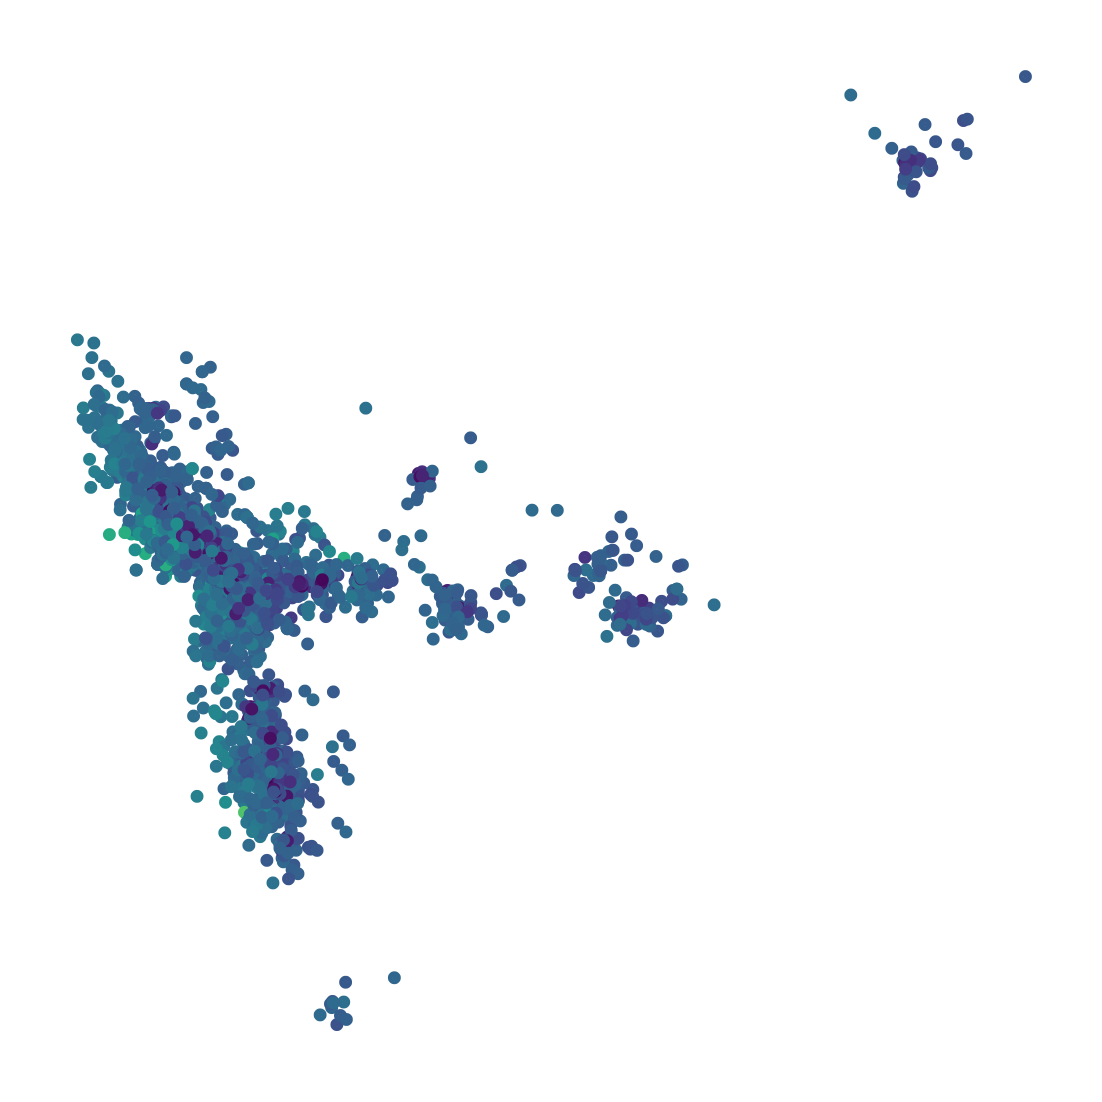

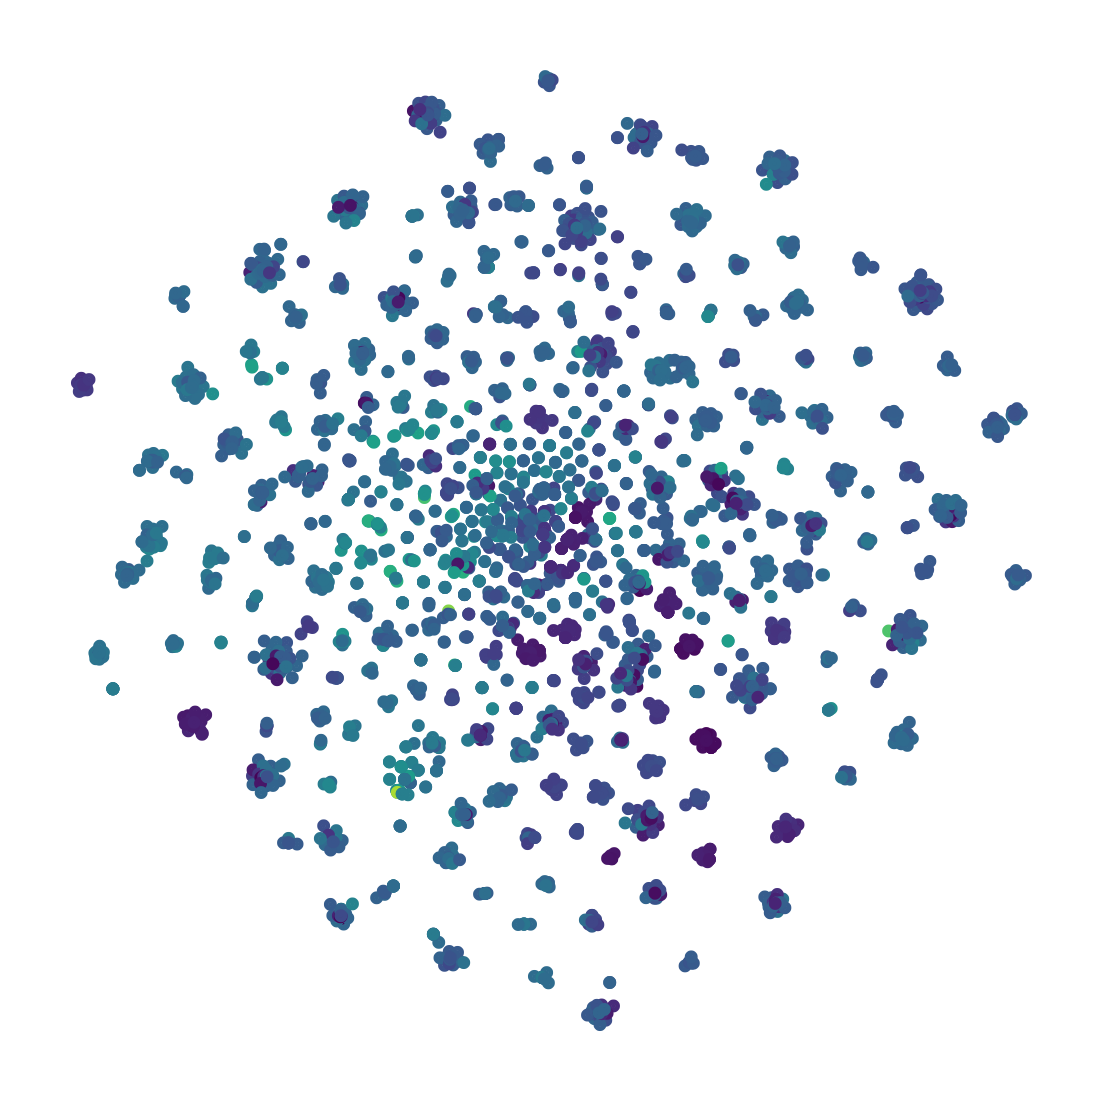

In [21]:
# Label logK and various features onto the tSNE and PCA embeddings

figure_dir = Path().cwd() / "figures"
fig, ax = plt.subplots()
ax.scatter(fps_pca[:,0],fps_pca[:,1],c=y_normed, marker="o", s = 0.3, cmap="viridis")
ax.set_box_aspect(1)
ax.set_axis_off()
# ax.set_title("logK")
fig.savefig(figure_dir / "pca" / f"logK.pdf")

fig, ax = plt.subplots()
ax.scatter(fps_tsne[:,0],fps_tsne[:,1],c=y_normed, marker="o", s=0.3)
ax.set_box_aspect(1)
ax.set_axis_off()
# ax.set_title("logK")
fig.savefig(figure_dir / "tsne" / f"logK.pdf")

for feature in features:
    pfz = PropFeaturizer([feature])
    fig, ax = plt.subplots()
    ax.scatter(fps_pca[:,0],fps_pca[:,1],
               c=scaler.fit_transform([pfz(Chem.MolFromSmiles(i)) for i in df["Solute"]]),
               marker="o", s=0.3)
    # ax.set_title(f"{feature}",fontsize=12)
    ax.set_box_aspect(1)
    ax.set_axis_off()
    fig.savefig(figure_dir / "pca" / f"solute_{feature}.pdf")
    plt.close()

    fig, ax = plt.subplots()
    ax.scatter(fps_pca[:,0],fps_pca[:,1],
               c=scaler.fit_transform([pfz(Chem.MolFromSmiles(i)) for i in df["Solvent"]]),
               marker="o", s=0.3)
    # ax.set_title(f"{feature}",fontsize=12)
    ax.set_box_aspect(1)
    ax.set_axis_off()
    fig.savefig(figure_dir / "pca" / f"solvent_{feature}.pdf")
    plt.close()
    
    fig, ax = plt.subplots()
    ax.scatter(fps_tsne[:,0],fps_tsne[:,1],
               c=scaler.fit_transform([pfz(Chem.MolFromSmiles(i)) for i in df["Solute"]]),
               marker="o", s=0.3)
    # ax.set_title(f"{feature}",fontsize=12)
    ax.set_box_aspect(1)
    ax.set_axis_off()
    fig.savefig(figure_dir / "tsne" / f"solute_{feature}.pdf")
    plt.close()
    
    fig, ax = plt.subplots()
    ax.scatter(fps_tsne[:,0],fps_tsne[:,1],
               c=scaler.fit_transform([pfz(Chem.MolFromSmiles(i)) for i in df["Solvent"]]),
               marker="o", s=0.3)
    # ax.set_title(f"{feature}",fontsize=12)
    ax.set_box_aspect(1)
    ax.set_axis_off()
    fig.savefig(figure_dir / "tsne" / f"solvent_{feature}.pdf")
    plt.close()

The TSNE and PCA embeddings look cool as figures, but they're not very informative on which physicochemical features from RDKit could be important for our problem. We can try to relate the structure of logK with the structure of the features. Patterns are visually evident in LASA, TPSA, logP, and MR, but they are not as evident elsewhere. We can also just do a simple regression to see how individual features are predictive of logK. Here, I'm not using regression in the predictive supervised learning framework, but rather from a statistical (classical) framework. We're trying to understand which features are significant, based on a linear model.

In [22]:
# Use RDKit features only
pf = PropFeaturizer(features)
dctors = np.hstack([np.vstack(df["Solvent"].apply(lambda x: pf(Chem.MolFromSmiles(x)))),
          np.vstack(df["Solute"].apply(lambda x: pf(Chem.MolFromSmiles(x))))])
df_dctors = pd.DataFrame(dctors)
df_dctors.columns = [f"solv_{f}" for f in features] + [f"solt_{f}" for f in features]
df_dctors["logK"] = y
# Use statsmodels API to do linear regression
result = sm.ols(formula="logK ~ -1 + " + " + ".join(df_dctors.columns[:-1]),data=df_dctors).fit()
result.summary()

# Warning!!! The condition number is high, suggesting colinearity in the input variables.
# Models may be sensitive to noise w.r.t. these physicochemical features.
# Molecular representations (e.g., fingerprints or message passing should be used)!

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   logK   R-squared (uncentered):                   0.947
Model:                            OLS   Adj. R-squared (uncentered):              0.947
Method:                 Least Squares   F-statistic:                              4056.
Date:                Thu, 09 May 2024   Prob (F-statistic):                        0.00
Time:                        21:12:40   Log-Likelihood:                         -3975.0
No. Observations:                3658   AIC:                                      7982.
Df Residuals:                    3642   BIC:                                      8081.
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
solv_TPSA                 -0.0260      0.003     -9.875      0.000      -0.031      -0.021
solv_LASA                  0.0204      0.004      4.824      0.000       0.012       0.029
solv_NumRotatableBonds     0.1014      0.009     10.775      0.000       0.083       0.120
solv_NumHDonors           -0.0745      0.036     -2.048      0.041      -0.146      -0.003
solv_NumHAcceptors         0.2251      0.037      6.098      0.000       0.153       0.298
solv_MolLogP              -0.0370      0.032     -1.148      0.251      -0.100       0.026
solv_MolMR                -0.0575      0.006     -9.184      0.000      -0.070      -0.045
solv_AromProp              0.3337      0.054      6.158      0.000       0.227       0.440
solt_TPSA                  0.0098      0.002      4.912      0.000       0.006       0.014
solt_LASA                  0.0237      0.002     15.338      0.000       0.021       0.027
solt_NumRotatableBonds    -0.1233      0.010    -11.952      0.000      -0.144      -0.103
solt_NumHDonors            0.6577      0.039     16.865      0.000       0.581       0.734
solt_NumHAcceptors        -0.0382      0.041     -0.933      0.351      -0.118       0.042
solt_MolLogP              -0.7470      0.036    -21.026      0.000      -0.817      -0.677
solt_MolMR                 0.1511      0.003     46.975      0.000       0.145       0.157
solt_AromProp              0.2745      0.055      5.025      0.000       0.167       0.382
==============================================================================
Omnibus:                      163.521   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              258.365
Skew:                           0.390   Prob(JB):                     7.88e-57
Kurtosis:                       4.042   Cond. No.                         379.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
# We find that the majority of RDKit features are important in explaining logK
# This suggests that we should include them in the regression models, because they could improve
# model accuracy beyond what is possible with fingerprint or message passing representations.
# Later on, we prove more rigorously for our D-MPNN through masking and cross validation
# that these features do improve model performance, and allows us to exceed benchmark_2 in Kaggle
[result.pvalues > 1e-5]

[solv_TPSA                 False
 solv_LASA                 False
 solv_NumRotatableBonds    False
 solv_NumHDonors            True
 solv_NumHAcceptors        False
 solv_MolLogP               True
 solv_MolMR                False
 solv_AromProp             False
 solt_TPSA                 False
 solt_LASA                 False
 solt_NumRotatableBonds    False
 solt_NumHDonors           False
 solt_NumHAcceptors         True
 solt_MolLogP              False
 solt_MolMR                False
 solt_AromProp             False
 dtype: bool]

# Chemprop (GNN)

In [8]:
# This is a dataloader class that I took from the Chemprop repository
# https://chemprop.readthedocs.io/en/main/_modules/chemprop/data/collate.html#MulticomponentTrainingBatch

# I'm redefining their MutliComponentTrainingBatch because I want to use features from both
# the solute and the solvent. More specifically, I am updating one line
# torch.cat([tbs[0].X_d,tbs[1].X_d],axis=1)

# The MulticomponentTrainingBatch sets up a DataLoader from a Dataset, and uses some collate
# function to take features from the batch e.g., bmg corresponds to the batch molecular graph,
# and X_d corresponds to the descriptor feature matrix e.g., as we defined using PropFeaturizer

# The collate function essentially combines the features from both datasets of the solute and
# solvent, and concatenates them together. Feature here refers to the 300 element vector from
# message passing and the 8 element vector from rdkit descriptors.

class MulticomponentTrainingBatch(NamedTuple):
    bmgs: list[BatchMolGraph]
    V_ds: list[Tensor | None]
    X_d: Tensor | None
    Y: Tensor | None
    w: Tensor
    lt_mask: Tensor | None
    gt_mask: Tensor | None


def custom_collate_multicomponent(batches: Iterable[Iterable[Datum]]) -> MulticomponentTrainingBatch:
    tbs = [collate_batch(batch) for batch in zip(*batches)]
    return MulticomponentTrainingBatch(
        [tb.bmg for tb in tbs], # Get molecular graph features
        [tb.V_d for tb in tbs],
        torch.cat([tbs[0].X_d,tbs[1].X_d],axis=1), # THIS IS WHERE I MODIFIED THEIR CLASS
        # Now we include the descriptor feature matrix for the solvent
        tbs[0].Y,
        tbs[0].w,
        tbs[0].lt_mask,
        tbs[0].gt_mask,
    )

def custom_build_dataloader(
    dataset: MoleculeDataset | ReactionDataset | MulticomponentDataset,
    batch_size: int = 64,
    num_workers: int = 0,
    class_balance: bool = False,
    seed: int | None = None,
    shuffle: bool = True,
    **kwargs,
):

    if class_balance:
        sampler = ClassBalanceSampler(dataset.Y, seed, shuffle)
    elif shuffle and seed is not None:
        sampler = SeededSampler(len(dataset), seed)
    else:
        sampler = None

    if isinstance(dataset, MulticomponentDataset):
        collate_fn = custom_collate_multicomponent # Here we change the collate function with our
        # own definition, which allows us to use solvent features
    else:
        collate_fn = collate_batch

    if len(dataset) % batch_size == 1:
        warnings.warn(
            f"Dropping last batch of size 1 to avoid issues with batch normalization \
(dataset size = {len(dataset)}, batch_size = {batch_size})"
        )
        drop_last = True
    else:
        drop_last = False
    # Output to PyTorch DataLoader
    return DataLoader(
        dataset,
        batch_size,
        sampler is None and shuffle,
        sampler,
        num_workers=num_workers,
        collate_fn=collate_fn,
        drop_last=drop_last,
        **kwargs,
    )
    
# I want to include solvent features because the solvation free energy depends on solvent-solute
# interactions, and as a first approximation I am assuming these features are equally descriptive
# of solvent properties. Not including these features means I'm imposing the inductive bias
# that these features are not important. Putting them in means I'm allowing my model to make
# the decision of whether these features are actually important. Letting the model make the
# decision for us is better if we have sufficient amount of data and good regularization.
# For now, I'll include them, and I can do a mask study to test it afterwards.

# In this work, I didn't actually do a mask differentiating solvent and solute features. This
# can be addressed in future work. However, looking at the properties of the models after masking,
# I doubt including these features would reduce the accuracy.

In [9]:
# A lot of what is done below was from the Chemprop documentation
# https://chemprop.readthedocs.io/en/main/training_regression_multicomponent.html
# of course, with modifications relevant to our system.

# Define features of interest, as discussed in the accompanying report
features = ["TPSA", "LASA", "NumRotatableBonds", "NumHDonors", "NumHAcceptors", "MolLogP", "MolMR", "AromProp"]

# Load the dataset
data_dir = Path.cwd() / "data"
train_file = data_dir / "solvation_train.csv"
test_file = data_dir / "solvation_test.csv"
prop_file = data_dir / "molecule_props.csv"
smiles_columns = ['Solute', 'Solvent'] # name of the column containing SMILES strings
target_columns = ['logK'] # list of names of the columns containing targets
df_input = pd.read_csv(train_file)
smiss = df_input.loc[:, smiles_columns].values
ys = df_input.loc[:, target_columns].values

# Use random splits 0.8/0.1/0.1 train test val
split_type="random"
split = (0.8, 0.1, 0.1)

# Define the RDKit featurizer
mfs = [PropFeaturizer(features)]
# Load the solute dataset, and featurize it using PropFeaturizer
# Include logK here
all_data = [[data.MoleculeDatapoint.from_smi(smis[0], y, mfs=mfs) for smis, y in zip(smiss, ys)]]
# Add onto the list the solvent dataset, and featurize it using PropFeaturizer
# Do not include logK since it was already loaded with the solute
all_data += [[data.MoleculeDatapoint.from_smi(smis[i], mfs=mfs) for smis in smiss] for i in range(1, len(smiles_columns))]

# Split by the solute. This does not matter since we're using random solit, but this setting
# could be important for scaffold splits.
component_to_split_by = 0
# Get the list of molecules to sort by
mols = [d.mol for d in all_data[component_to_split_by]]

# Generate random splits
train_indices, val_indices, test_indices = data.make_split_indices(mols, split_type, split)

# Load the random splits
train_data, val_data, test_data = data.split_data_by_indices(
    all_data, train_indices, val_indices, test_indices
)

# Turn the molecule into a graph
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

# Now, from the molecule data points before, create a Molecule Dataset for the solvent and solute
# each, and combine them into a MulticomponentDataset, which we then input to build a DataLoader
# Use the molecule graph featurizer here
train_datasets = [data.MoleculeDataset(train_data[i], featurizer) for i in range(len(smiles_columns))]
train_mcdset = data.MulticomponentDataset(train_datasets)
scaler_target = train_mcdset.normalize_targets()
scaler_input = train_mcdset.normalize_inputs(key="X_d")
train_loader = custom_build_dataloader(train_mcdset)

# `Repeat the same process for the validation set
val_datasets = [data.MoleculeDataset(val_data[i], featurizer) for i in range(len(smiles_columns))]
val_mcdset = data.MulticomponentDataset(val_datasets)
val_mcdset.normalize_targets(scaler_target)
val_mcdset.normalize_inputs(key="X_d",scaler=scaler_input)
val_loader = custom_build_dataloader(val_mcdset, shuffle=False)

# `Repeat the same process for the test set
test_datasets = [data.MoleculeDataset(test_data[i], featurizer) for i in range(len(smiles_columns))]
test_mcdset = data.MulticomponentDataset(test_datasets)
test_mcdset.normalize_inputs(key="X_d",scaler=scaler_input)
test_loader = custom_build_dataloader(test_mcdset, shuffle=False)

In [12]:
# This is my custom MulticomponentMPNN class, to make it easier to optimize hyperparameters.
# I'm just aggregating all the definitions and functions into this class.

class MulticomponentMPNN:
    def __init__(self, smiles_columns, scaler_target, features, hidden_dim=1900, n_layers=2, dropout=0.008, depth=6, max_lr=0.001):
        # Initialize the MPNN built into chemprop
        self.mcmp = nn.MulticomponentMessagePassing(
            blocks=[nn.BondMessagePassing(depth=depth) for _ in range(len(smiles_columns))],
            n_components=len(smiles_columns),
        )

        # Mean aggregation
        self.agg = nn.MeanAggregation()

        # We want to return the output predictions into unitful solvation free energies
        self.output_transform = nn.UnscaleTransform.from_standard_scaler(scaler_target)

        # Fully connected feedforward network
        self.ffn = nn.RegressionFFN(
            input_dim=self.mcmp.output_dim + 2 * len(features),
            # self.mcmp.output_dim gives 600, which corresponds to the two concatenated
            # molecular graph vectors.
            # 2*len(features) here corresponds to the 2 feature vectors for the solvent and 
            # solute, calculated usign rdkit
            output_transform=self.output_transform,
            hidden_dim=hidden_dim,
            n_layers=n_layers,
            dropout=dropout,
        )

        # We use RMSE for the training, and MAE/R2 for statistics
        self.metric_list = [nn.metrics.RMSEMetric(), nn.metrics.MAEMetric(), nn.metrics.R2Metric()]

        # Combine everything into the this MulticomponentMPNN model
        # This model goes into PyTorch lightning
        self.model = models.multi.MulticomponentMPNN(
            self.mcmp,
            self.agg,
            self.ffn,
            metrics=self.metric_list,
            max_lr=max_lr
        )

    def get_model(self):
        return self.model
    
# Now define our model with a set of hyperparameters
mcmpnn = MulticomponentMPNN(smiles_columns, scaler_target, features, hidden_dim=1900, n_layers=2, dropout=0.008)

/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.


In [ ]:
# Sanity check the internal structure of our model
# This looks good!
print(mcmpnn.get_model())

MulticomponentMPNN(
  (message_passing): MulticomponentMessagePassing(
    (blocks): ModuleList(
      (0-1): 2 x BondMessagePassing(
        (W_i): Linear(in_features=86, out_features=300, bias=False)
        (W_h): Linear(in_features=300, out_features=300, bias=False)
        (W_o): Linear(in_features=372, out_features=300, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (tau): ReLU()
        (V_d_transform): Identity()
        (graph_transform): Identity()
      )
    )
  )
  (agg): MeanAggregation()
  (bn): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=616, out_features=1900, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.008, inplace=False)
        (2): Linear(in_features=1900, out_features=1900, bias=True)
      )
      (2): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.008, i

In [ ]:
# Use a CSVLogger to check the validation error. We want to pay attention to the validation error
# over epoch because it shows whether we are overfitting the data. Interestingly, an MLP
# trained using fingerprints will have a validation error which decreases then increases, signifying
# overfitting. We do not observe this trend with the D-MPNN, and after some large number of epochs
# the validation error plateaus.

# Remember that the model cannot see the validation error, so it should be our proxy during
# training for whether the model generalizes well.
logger = CSVLogger("logs", name="model")

# Let's create a PyTorch lightning trainer, use a GPU, and view the training using a progress bar
# We'll use 200 as an epoch for now and tune it later
trainer = pl.Trainer(
    logger=logger,
    enable_checkpointing=True,
    enable_progress_bar=True,
    accelerator="gpu",
    devices=1,
    max_epochs=200, # number of epochs to train for
)

# Train the model
trainer.fit(mcmpnn.get_model(), train_loader, val_loader)

/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/gridsan/ddavid/.conda/envs/torch/lib/python3.1 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.


Epoch 199: 100%|██████████| 46/46 [00:01<00:00, 33.55it/s, v_num=23, train_loss=0.00231, val_loss=0.129] 

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 46/46 [00:01<00:00, 30.49it/s, v_num=23, train_loss=0.00231, val_loss=0.129]


In [ ]:
# Let's view the results!
results = trainer.test(mcmpnn.get_model(), test_loader)
# Out of the box, the D-MPNN has a test r-squared of 0.99!!! I don't think we need to look at other
# models, but I still will because by using Chemprop I didn't have to build my own models from the
# ground up.

# Note that hidden_dim=1900, n_layers=2, dropout=0.008 are parameters from hyperparameter tuning.
# I'll show my hyperparameter tuning workflow in a later part of this Jupyter notebook.

# These values were from my first round of hyperparameter tuning (200 iterations), where I only
# focused at width, depth, and dropout. The hyperparaemter tuning code I have below also tunes
# for the learning rate in Adam. This was my third round of hyperparameter tuning (200 iterations).
# I forgot what I did in my second round, and I'm not including those results here.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 47.80it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 batch_averaged_test/mae    0.10145554691553116
 batch_averaged_test/r2     0.9895522594451904
batch_averaged_test/rmse    0.15969231724739075
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [ ]:
# We can now define a similar DataLoader for the Kaggle dataset ...
kaggle_path = data_dir / "solvation_test.csv"
df_kaggle = pd.read_csv(kaggle_path)
smiss_kaggle = df_kaggle.loc[:, smiles_columns].values
kaggle_data = [[data.MoleculeDatapoint.from_smi(smis[0], mfs=mfs) for smis in smiss_kaggle]]
kaggle_data += [[data.MoleculeDatapoint.from_smi(smis[1], mfs=mfs) for smis in smiss_kaggle]]
kaggle_datasets = [data.MoleculeDataset(kaggle_data[i], featurizer) for i in range(len(smiles_columns))]
kaggle_mcdset = data.MulticomponentDataset(kaggle_datasets)
# kaggle_mcdset.normalize_inputs(key="X_d",scaler=scaler_input)
kaggle_loader = custom_build_dataloader(kaggle_mcdset,shuffle=False)

In [ ]:
# ... and make some predictions to submit to Kaggle!
test_preds = trainer.predict(mcmpnn.get_model(), kaggle_loader)
test_preds = np.concatenate(test_preds, axis=0)
formatted_time = datetime.now().strftime("%Y%m%d-%H%M")
save_submission(test_preds.squeeze(),f"kaggle/chemprop_{formatted_time}.csv")

/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/gridsan/ddavid/.conda/envs/torch/lib/python3.1 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 25/25 [00:00<00:00, 55.83it/s]


In [ ]:
# Here is my hyperparameter tuning code
# I'm using Optuna to minimize the validation mean squared error. Optuna uses Bayesian optimization,
# so at every iteration of tuning it tries to move the model in the hyperparameter space towards
# a smaller validation error. This corresponds to trying to tune the model to unseen data, which
# entails generalization/not overfitting.

# Bayesian optimization is a lot smarter than grid search, and is actually quite great for tuning
# machine learning models.

# Optuna also prunes unpromising models. We describe it both in the text and below.

In [ ]:
def objective(trial: optuna.Trial) -> float:
    # Let optuna suggest based on its optimization algorithm
    hidden_dim = trial.suggest_int("hidden_dim", 100, 2400)
    n_layers = trial.suggest_int("n_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    depth = trial.suggest_int("depth", 2, 6)
    max_epochs = trial.suggest_int("max_epochs", 50, 200)
    max_lr = trial.suggest_float("lr", 1e-3, 0.1, log=True)

    # Define a new neural network
    mcmpnn = MulticomponentMPNN(smiles_columns, scaler, features, hidden_dim=hidden_dim, n_layers=n_layers, dropout=dropout, depth=depth, max_lr=max_lr)

    # Generate logs in CSV
    logger = CSVLogger("logs", name="hyperparameter")

    # Train a model
    trainer = pl.Trainer(
        logger=logger,
        enable_checkpointing=True,
        callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_loss")],
        enable_progress_bar=False,
        accelerator="gpu",
        devices=1,
        max_epochs=max_epochs, # number of epochs to train for
    )

    # Log our hyperparameters
    hyperparameters = dict(hidden_dim=hidden_dim, n_layers=n_layers, dropout=dropout, depth=depth, max_epochs=max_epochs)
    trainer.logger.log_hyperparams(hyperparameters)
    trainer.fit(mcmpnn.get_model(), train_loader, val_loader)  # Define your dataloaders properly

    # Report the validation loss using callback_metrics
    # What this means is that Optuna gets access to the validation loss at every epoch. This
    # allows it to prune unpromising models early on, saving training time and allowing us
    # to investigate a larger hyperparameter space. Whether pruning works or not, I'm not so sure.
    # My intuition from looking at the iterative improvement during tuning suggests that
    # pruning works better for the D-MPNN than for the fingerprint-based FNN (the FNN is a lot
    # more unstable and jiterry, perhaps because of the sparsity of the fingerprint). Pruning
    # works better for stable datasets.

    return trainer.callback_metrics["val_loss"].item()  # Or any other metric that you aim to minimize

# Use the HyperbandPruner() (state of the art? according to reddit?!), which cuts off unpromising
# trials and allows us to look at a larger hyperparameter space. However, the validation error
# tends to be jittery, so we should wrap this around a PatientPruner with some number of unpromising
# epochs before we cut it off (here patience is set to 3, it's an arbitrary number). We actually
# have the resources to not use a pruner, but I don't think we have to go that far for this
# Kaggle benchmark.

pruner = optuna.pruners.PatientPruner(optuna.pruners.HyperbandPruner(), patience=3)
study = optuna.create_study(direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=200)
# I did 200 trials but really we can do more.

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
    
# The result for this hyperparameter tuning is in hyperparameter3_optuna.out in my GitHub repo
# https://github.com/gohdavid/ml4me/blob/main/scripts/hyperparameter3_optuna.out
# It's not in this notebook because 1) it would be too long and 2) I ran it with a job.

```
Best trial:
  Value: 0.10686355084180832
  Params: 
    hidden_dim: 1923
    n_layers: 2
    dropout: 0.016717180169380612
    depth: 5
    max_epochs: 89
    lr: 0.006944491033377218
``````

In [15]:
# Here, we do 5-fold cross validation to evaluate the model's performance. This will become part 
# of my bar plot in Figure 2!

# All the code in here is just copied from above and put inside a for loop

import warnings
# We use sklearn to generate 5-fold splits
kf = KFold(n_splits=5)
result_lst = []
# We use test/train 5-fold splits to evaluate our model performance
for i, (train_indices, test_indices) in enumerate(kf.split(mols)):
    train_data, val_data, test_data = data.split_data_by_indices(
        all_data, train_indices, [0], test_indices
        # We actually don't want any validation sets, so I'm just using index [0] here because
        # we still need some value for val_indices to use this helper function from Chemprop.
        # It doesn't affect our splits at all.
    )

    featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

    train_datasets = [data.MoleculeDataset(train_data[i], featurizer) for i in range(len(smiles_columns))]
    train_mcdset = data.MulticomponentDataset(train_datasets)
    scaler_target = train_mcdset.normalize_targets()
    # scaler_input = train_mcdset.normalize_inputs(key="X_d")
    train_loader = custom_build_dataloader(train_mcdset)

    val_datasets = [data.MoleculeDataset(val_data[i], featurizer) for i in range(len(smiles_columns))]
    val_mcdset = data.MulticomponentDataset(val_datasets)
    val_mcdset.normalize_targets(scaler_target)
    # val_mcdset.normalize_inputs(key="X_d",scaler=scaler_input)
    val_loader = custom_build_dataloader(val_mcdset, shuffle=False)

    test_datasets = [data.MoleculeDataset(test_data[i], featurizer) for i in range(len(smiles_columns))]
    test_mcdset = data.MulticomponentDataset(test_datasets)
    # test_mcdset.normalize_inputs(key="X_d",scaler=scaler_input)
    test_loader = custom_build_dataloader(test_mcdset, shuffle=False)
    
    mcmpnn = MulticomponentMPNN(smiles_columns, scaler_target, features, hidden_dim=1923, n_layers=2,
                                dropout=0.016717180169380612, max_lr=0.006944491033377218, depth=5)

    logger = CSVLogger("logs", name="model")

    trainer = pl.Trainer(
            logger=logger,
            enable_checkpointing=True,
            enable_progress_bar=True,
            accelerator="gpu",
            devices=1,
            max_epochs=89, # number of epochs to train for
        )

    trainer.fit(mcmpnn.get_model(), train_loader, val_loader)
    results = trainer.test(mcmpnn.get_model(), test_loader)
    result_lst.append(results[0]["batch_averaged_test/r2"])

/tmp/ipykernel_2956191/2016782832.py:46: UserWarning: Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
  warnings.warn(
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/gridsan/ddavid/.conda/envs/torch/lib/python3.1 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOC

Loading `train_dataloader` to estimate number of stepping batches.
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.

  | Name            | Type                         | Params
-----------------------------------------------------------------
0 | message_passing | MulticomponentMessagePassing | 455 K 
1 | agg             | MeanAggregation              | 0     
2 | bn              | BatchNorm1d                  | 1.

/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:104: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.


Epoch 88: 100%|██████████| 46/46 [00:01<00:00, 37.83it/s, v_num=426, train_loss=0.00136] 

`Trainer.fit` stopped: `max_epochs=89` reached.


Epoch 88: 100%|██████████| 46/46 [00:01<00:00, 34.30it/s, v_num=426, train_loss=0.00136]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 48.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 batch_averaged_test/mae    0.09952425211668015
 batch_averaged_test/r2      0.990231990814209
batch_averaged_test/rmse    0.16667978465557098
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/tmp/ipykernel_2956191/2016782832.py:46: UserWarning: Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
  warnings.warn(
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/gridsan/ddavid/.conda/envs/torch/lib/python3.1 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOC

/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:104: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.


Epoch 88: 100%|██████████| 46/46 [00:01<00:00, 37.91it/s, v_num=427, train_loss=0.00237] 

`Trainer.fit` stopped: `max_epochs=89` reached.


Epoch 88: 100%|██████████| 46/46 [00:01<00:00, 32.36it/s, v_num=427, train_loss=0.00237]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.



Testing DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 47.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 batch_averaged_test/mae    0.09727423638105392
 batch_averaged_test/r2     0.9913933873176575
batch_averaged_test/rmse    0.1575765460729599
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/tmp/ipykernel_2956191/2016782832.py:46: UserWarning: Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
  warnings.warn(
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/gridsan/ddavid/.conda/envs/torch/lib/python3.1 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOC

/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:104: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.


Epoch 88: 100%|██████████| 46/46 [00:01<00:00, 37.74it/s, v_num=428, train_loss=0.00255] 

`Trainer.fit` stopped: `max_epochs=89` reached.


Epoch 88: 100%|██████████| 46/46 [00:01<00:00, 34.09it/s, v_num=428, train_loss=0.00255]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 47.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 batch_averaged_test/mae    0.0980943813920021
 batch_averaged_test/r2     0.9895720481872559
batch_averaged_test/rmse     0.164480522274971
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/tmp/ipykernel_2956191/2016782832.py:46: UserWarning: Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
  warnings.warn(
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/gridsan/ddavid/.conda/envs/torch/lib/python3.1 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOC

/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:104: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.


Epoch 88: 100%|██████████| 46/46 [00:01<00:00, 37.89it/s, v_num=429, train_loss=0.00266] 

`Trainer.fit` stopped: `max_epochs=89` reached.


Epoch 88: 100%|██████████| 46/46 [00:01<00:00, 34.22it/s, v_num=429, train_loss=0.00266]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 49.09it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 batch_averaged_test/mae    0.1004645898938179
 batch_averaged_test/r2     0.9875091910362244
batch_averaged_test/rmse    0.1690697818994522
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/tmp/ipykernel_2956191/2016782832.py:46: UserWarning: Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
  warnings.warn(
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/gridsan/ddavid/.conda/envs/torch/lib/python3.1 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOC

/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:104: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.


Epoch 88: 100%|██████████| 46/46 [00:01<00:00, 38.06it/s, v_num=430, train_loss=0.00186] 

`Trainer.fit` stopped: `max_epochs=89` reached.


Epoch 88: 100%|██████████| 46/46 [00:01<00:00, 34.46it/s, v_num=430, train_loss=0.00186]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 48.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 batch_averaged_test/mae    0.09760073572397232
 batch_averaged_test/r2     0.9896097779273987
batch_averaged_test/rmse    0.16167032718658447
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [16]:
write("DMPNN",result_lst)

# XGBoost

In [ ]:
# We just made a Chemprop model that beats all the benchmarks ... but I should still try more
# models that are more difficult to set up than reading (and modifying code) from the Chemprop
# documentation. Let's try XGBoost.

# This is the exact same fingerprint and PropFeaturizer featurizing function from many cells
# before

def featurize(smiles):
    mol = Chem.MolFromSmiles(smiles) # load SMILES into RDKit
    fp = AllChem.GetMorganGenerator(radius=2, fpSize=1024)
    fp_array = np.array(fp.GetFingerprint(mol))
    featurizer = PropFeaturizer(features)
    return np.hstack([fp_array, featurizer(mol)])

In [ ]:
# This is the exact same code copied over for producing the feature matrix and output matrix

data_dir = Path.cwd() / "data"
train_file = data_dir / "solvation_train.csv"
test_file = data_dir / "solvation_test.csv"
prop_file = data_dir / "molecule_props.csv"
df = pd.read_csv(train_file) # load data
mol_prop = pd.read_csv(prop_file)
y = df["logK"]
X_solvent = np.stack(df["Solvent"].apply(featurize).values)
X_solute = np.stack(df["Solute"].apply(featurize).values)
X = np.hstack([X_solvent,X_solute])

In [ ]:
# Why use these hyperparameters? We discuss this in the accompanying report.

# XGBoost actually performs well out-of-the-box, but it was a underwhelming. I wanted to 
# see how far we can push XGBoost to perform, and to compare that with the D-MPNN.

# XGBoost is a lot cheaper to train than a D-MPNN, especially since we have access to a GPU.
# Now, we can use 5-fold cross validation r-squared to tune the hyperparameters for XGBoost.
# This is more robust! The reason I'm using r-squared maximization and not MSE minimization here
# just has to do with how cross_val_score is defined. cross_val_score tries to indicate performance,
# so it can only give out negative MSE. I found out about this after tuning to r-squared for 100
# iterations, so we'll just stick to that.

def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "device": "cuda"
    }

    bst = XGBRegressor(**params)
    # Use the standard scaler!
    pipe = Pipeline([('scaler', StandardScaler()), ('model', bst)])
    # Do 5-fold cross validation
    scores = cross_val_score(pipe, X, y, cv = 5, scoring = "r2")
    return scores.mean()

In [79]:
# Let's tune for 100 iterations! We could do more iterations, but my gut feeling says the
# model won't improve too much ...

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-05-06 15:49:44,724] A new study created in memory with name: no-name-ab86d0cd-6675-4ffd-995e-b8d772c4546d
[I 2024-05-06 15:49:59,453] Trial 0 finished with value: 0.9314558463266639 and parameters: {'n_estimators': 620, 'learning_rate': 0.01881907824016294, 'max_depth': 3, 'subsample': 0.3654950657585666, 'colsample_bytree': 0.8612461064872369, 'min_child_weight': 14}. Best is trial 0 with value: 0.9314558463266639.
[I 2024-05-06 15:50:13,045] Trial 1 finished with value: 0.6227098201036345 and parameters: {'n_estimators': 452, 'learning_rate': 0.0013801994568370182, 'max_depth': 10, 'subsample': 0.7791248907072018, 'colsample_bytree': 0.6323995345043142, 'min_child_weight': 19}. Best is trial 0 with value: 0.9314558463266639.
[I 2024-05-06 15:50:18,660] Trial 2 finished with value: 0.9609057342033708 and parameters: {'n_estimators': 507, 'learning_rate': 0.08271379894698898, 'max_depth': 5, 'subsample': 0.7626307577689471, 'colsample_bytree': 0.6406831709648182, 'min_child_wei

In [87]:
# Our model got an r-squared of 98%! That's surprisingly cool that code this simple can take us so
# far!

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
params = trial.params
params["objective"] =  "reg:squarederror"
params["verbosity"] =  0
params["device"] =  "cuda"
params

Best trial:
  Value: 0.9799330132403803
  Params: 
    n_estimators: 850
    learning_rate: 0.043618536313187406
    max_depth: 9
    subsample: 0.7554948276711327
    colsample_bytree: 0.6508682722614273
    min_child_weight: 1


{'n_estimators': 850,
 'learning_rate': 0.043618536313187406,
 'max_depth': 9,
 'subsample': 0.7554948276711327,
 'colsample_bytree': 0.6508682722614273,
 'min_child_weight': 1,
 'objective': 'reg:squarederror',
 'verbosity': 0,
 'device': 'cuda'}

In [17]:
# Now that we have an optimized XGBoost model, let's try to optimize for the fingerprints!
# There are only four types of fingerprints we are investigating (AtomPair lead to memory issues),
# so let's just do a grid search. This is part of one of our tables in the accompanying report.

params = {'n_estimators': 850,
 'learning_rate': 0.043618536313187406,
 'max_depth': 9,
 'subsample': 0.7554948276711327,
 'colsample_bytree': 0.6508682722614273,
 'min_child_weight': 1,
 'objective': 'reg:squarederror',
 'verbosity': 0,
 'device': 'cuda'}

fingerprinters = {"RDKit":AllChem.GetRDKitFPGenerator().GetFingerprint,
"TopologicalTorsion":AllChem.GetTopologicalTorsionGenerator().GetFingerprint,
"Morgan":AllChem.GetMorganGenerator().GetFingerprint,
"Avalon":GetAvalonFP,
}

def objective(trial):
    features = ["TPSA", "LASA", "NumRotatableBonds", "NumHDonors", "NumHAcceptors", "MolLogP", "MolMR", "AromProp"]

    fp = trial.suggest_categorical("fingerprint", ["RDKit", "Morgan", "TopologicalTorsion", "Avalon"])
    
    def featurize(smiles):
        mol = Chem.MolFromSmiles(smiles) # load SMILES into RDKit
        fp_array = np.array(fingerprinters[fp](mol))
        featurizer = PropFeaturizer(features)
        return np.hstack([fp_array, featurizer(mol)])

    data_dir = Path.cwd() / "data"
    train_file = data_dir / "solvation_train.csv"
    test_file = data_dir / "solvation_test.csv"
    prop_file = data_dir / "molecule_props.csv"
    df = pd.read_csv(train_file) # load data
    mol_prop = pd.read_csv(prop_file)
    y = df["logK"]
    X_solvent = np.stack(df["Solvent"].apply(featurize).values)
    X_solute = np.stack(df["Solute"].apply(featurize).values)
    X = np.hstack([X_solvent,X_solute])

    bst = XGBRegressor(**params)
    pipe = Pipeline([('scaler', StandardScaler()), ('model', bst)])
    scores = cross_val_score(pipe, X, y, cv = 5, scoring = "r2")
    return scores.mean()

In [18]:
search_space = {"fingerprint": ["RDKit", "Morgan", "TopologicalTorsion", "Avalon"]}

In [13]:
# As highly optimized in-house fingerprints, Avalon performs the best, but only marginally
# from Morgan. I decided to stick with Morgan because we should keep it simple and use the most
# common fingerprint.

study = optuna.create_study(sampler=optuna.samplers.GridSampler(search_space=search_space),direction="maximize")
study.optimize(objective, n_trials=4)

[I 2024-05-06 17:16:31,885] A new study created in memory with name: no-name-7dd6d12f-3815-4231-b167-9d596ddd4275
[I 2024-05-06 17:17:00,415] Trial 0 finished with value: 0.9795121505157198 and parameters: {'fingerprint': 'Morgan'}. Best is trial 0 with value: 0.9795121505157198.
[I 2024-05-06 17:17:33,096] Trial 1 finished with value: 0.9774261767734679 and parameters: {'fingerprint': 'RDKit'}. Best is trial 0 with value: 0.9795121505157198.
[I 2024-05-06 17:17:54,623] Trial 2 finished with value: 0.9796385900905642 and parameters: {'fingerprint': 'Avalon'}. Best is trial 2 with value: 0.9796385900905642.
[I 2024-05-06 17:18:24,409] Trial 3 finished with value: 0.9779505049994196 and parameters: {'fingerprint': 'TopologicalTorsion'}. Best is trial 2 with value: 0.9796385900905642.


In [19]:
# Alright, now let's do five-fold cross validation usign XGBoost!

bst = XGBRegressor(**params)
pipe = Pipeline([('scaler', StandardScaler()), ('model', bst)])
scores = cross_val_score(pipe, X, y, cv = 5, scoring = "r2")
print(f"XGBoost R2: {scores.mean()}")
write("XGBoost",scores)
bst.fit(X,y)

# It barely managed to beat benchmark_1, but it fails to beat benchmark_2!

XGBoost R2: 0.9784718473940185


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6508682722614273, device='cuda',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.043618536313187406, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=850, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Apply this to Kaggle test set
# As expected, my XGBoost model underperforms compared to the D-MPNN. It got quite far though!
bst = XGBRegressor(**params)
bst.fit(X,np.array(y))
predict = bst.predict(X_kaggle)

In [ ]:
formatted_time = datetime.now().strftime("%Y%m%d-%H%M")
save_submission(np.array(predict),f"kaggle/xgboost_{formatted_time}.csv")

# Random Forest

In [ ]:
# I'm training a Random Forest just to show how much better XGBoost is for this data.
# We also discuss these hyperparameters in the accompanying report!
# Optuna optimization is done similarly to XGBoost's

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical("max_features", ['sqrt', 'log2'])
    }

    reg = RandomForestRegressor(**params)
    pipe = Pipeline([('scaler', StandardScaler()), ('model', reg)])
    scores = cross_val_score(pipe, X, y, cv = 5, scoring = "r2")
    return scores.mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-05-05 16:21:00,882] A new study created in memory with name: no-name-8b88dac8-4e95-476d-bd83-7e2411c4e294
[I 2024-05-05 16:21:03,918] Trial 0 finished with value: 0.49786962674195284 and parameters: {'n_estimators': 293, 'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.49786962674195284.
[I 2024-05-05 16:21:10,751] Trial 1 finished with value: 0.42358861500157935 and parameters: {'n_estimators': 871, 'max_depth': 9, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 0 with value: 0.49786962674195284.
[I 2024-05-05 16:21:15,633] Trial 2 finished with value: 0.4094141827138721 and parameters: {'n_estimators': 596, 'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.49786962674195284.
[I 2024-05-05 16:21:18,682] Trial 3 finished with value: 0.18884169630155895 and parameters: {'n_estimators': 474, 'max_depth': 

In [20]:
# Oh ... it's not that great. It's no better than a linear model!!!

params = {
    "n_estimators": 452,
    "max_depth": 10,
    'min_samples_split': 3,
    'min_samples_leaf': 1,
    'max_features': "sqrt"
}

reg = RandomForestRegressor(**params)
pipe = Pipeline([('scaler', StandardScaler()), ('model', reg)])
scores = cross_val_score(pipe, X, y, cv = 5, scoring = "r2")
print(f"RandomForest R2: {scores.mean()}")
write("RandomForest",scores)

RandomForest R2: 0.7145852105049967


# MLP Fingerprint Regression

In [19]:
# Here, I decided to make my own FNN (MLP) implementation in PyTorch just cause.

from torch.utils.data import Dataset, DataLoader
fpSize = 1024

# Features, as done before
features = ["TPSA", "LASA", "NumRotatableBonds", "NumHDonors", "NumHAcceptors", "MolLogP", "MolMR", "AromProp"]
def featurize(smiles):
    mol = Chem.MolFromSmiles(smiles) # load SMILES into RDKit
    fp = AllChem.GetMorganGenerator(radius=2, fpSize=fpSize)
    fp_array = np.array(fp.GetFingerprint(mol))
    featurizer = PropFeaturizer(features)
    return np.hstack([fp_array, featurizer(mol)])

# Data, as done before
y = df["logK"]
X_solvent = np.stack(df["Solvent"].apply(featurize).values)
X_solute = np.stack(df["Solute"].apply(featurize).values)
X = np.hstack([X_solvent,X_solute])

# Dataset, just like all our PSets
class Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(np.array(X))  # store X as a pytorch Tensor
        self.y = torch.Tensor(np.array(y))  # store y as a pytorch Tensor
        self.len=len(self.X)                # number of samples in the data

    def __getitem__(self, index):
        return self.X[index], self.y[index] # get the appropriate item

    def __len__(self):
        return self.len

In [20]:
# Test train split with sklearn, as usual
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,train_size=0.9)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.1/0.9,train_size=0.8/0.9)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

train_data = Dataset(X_train,y_train)
val_data = Dataset(X_val,y_val)
test_data = Dataset(X_test,y_test)

batch_size = 256
# Put into DataLoader, as usual
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# Don't shuffle val and test, this is standard practice?
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
# Batch size should be optimized but let's not go through that for now.

In [21]:
# This is different. I tried defining the FFn in PyTorch lightning instead. It's quite similar
# to PyTorch.
class FFN(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim=256, n_layers=1, dropout=0, lr=0.001):
        super().__init__()
        self.lr = lr
        # First layer to pull in the data
        model = [torch.nn.Linear(input_dim, hidden_dim), torch.nn.ReLU(), torch.nn.Dropout(dropout)]
        # Hidden layers with n_layers depth
        model += [torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU(), torch.nn.Dropout(dropout)] * n_layers
        # Final regression layer
        model.append(torch.nn.Linear(hidden_dim, 1))  # Final layer
        # Place all of these into torch.nn.sequential
        self.model = torch.nn.Sequential(*model)

    def forward(self, x):
        # Make array one-dimensional
        x = x.squeeze()
        # Forward mode
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        # Make a prediction, and evaluate the error
        loss = torch.nn.functional.mse_loss(output.squeeze(), y) 
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        # Evaluate on the validation set. We don't need to switch between trian and eval
        # mode because this is taken care of by Lightning
        loss = torch.nn.functional.mse_loss(output.squeeze(), y) 
        self.log("val_loss", loss, prog_bar=True)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        # When we evaluate on the test set, we also want to look at r-squared
        loss = torch.nn.functional.mse_loss(output.squeeze(), y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_r2", r2(output.squeeze(),y), prog_bar=True)

    def configure_optimizers(self):
        # Use the Adam optimizer ... I should've tuned the decay rate
        # (regularization parameter) but I did not
        return torch.optim.Adam(self.parameters(),lr=self.lr)

In [22]:
# Keep it simple in the output of this notebook
import logging
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

In [ ]:
# Hyperparameter tuning using optuna with the same principles.
# Difference now is that we have dimensions fpSize*2 concatenated for the first input layer
# of our neural network. Everything else is the same. I also did this tuning inside a slurm job,
# so you won't see the output here.
# The output is here https://github.com/gohdavid/ml4me/blob/main/scripts/hyperparameter_mlp.py

def objective(trial):
    params = {
        "hidden_dim": trial.suggest_int("hidden_dim", 200, 2400),
        "n_layers": trial.suggest_int("n_layers", 1, 5),
        'dropout': trial.suggest_float("dropout", 0.0, 0.4),
        "lr": trial.suggest_float("lr", 1e-3, 0.1, log=True),
    }
    max_epochs =  trial.suggest_int("max_epochs", 50, 200)

    ffn = FFN(input_dim=fpSize*2+len(features)*2, **params)

    logger = CSVLogger("logs", name="model")

    trainer = pl.Trainer(
        logger=logger,
        enable_checkpointing=True,
        callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_loss")],
        enable_progress_bar=False,
        accelerator="gpu",
        devices=1,
        max_epochs=max_epochs, # number of epochs to train for
    )

    hyperparameters = dict(max_epochs=max_epochs, **params)
    trainer.logger.log_hyperparams(hyperparameters)
    trainer.fit(ffn, train_loader, val_loader)  # Define your dataloaders properly

    return trainer.callback_metrics["val_loss"].item()  # Or any other metric that you aim to minimize

# Create a study and execute optimization
pruner = optuna.pruners.PatientPruner(optuna.pruners.HyperbandPruner(), patience=3)
study = optuna.create_study(direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=200)  # You can adjust the number of trials

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

In [ ]:
# Similarly do 5-fold CV

kf = KFold(n_splits=5)
result_lst = []
for i, (train_indices, test_indices) in enumerate(kf.split(mols)):
    X_train = X[train_indices,:]
    y_train = np.array(y)[train_indices]
    X_test = X[test_indices,:]
    y_test = np.array(y)[test_indices]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    train_data = Dataset(X_train,y_train)
    test_data = Dataset(X_test,y_test)

    batch_size = 64
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    
    hidden_dim = 256
    n_layers = 3
    dropout = 0.04625202733030247
    lr = 0.001081576060046395

    ffn = FFN(input_dim=fpSize*2+len(features)*2, hidden_dim=hidden_dim, n_layers=n_layers, dropout=dropout, lr=lr)

    logger = CSVLogger("logs", name="model")

    trainer = pl.Trainer(
        logger=logger,
        enable_checkpointing=True,
        enable_progress_bar=False,
        accelerator="gpu",
        devices=1,
        max_epochs=160, # number of epochs to train for
    )

    trainer.fit(ffn, train_loader)
    results = trainer.test(ffn, test_loader)
    result_lst.append(results[0]["test_r2"])

In [53]:
# It's worse than sklearn's MLP!!!!!! 
# This is the same thing that happened in one of the other PSets, and I have no idea why.
# Sometime in the future I should dig deeper what the secret sauce hyperparameter in sklearn's
# MLPRegressor is, because it seems to perform better than my implementation in PyTorch.

# What I noticed is that the performance of the model is sensitive to max_epochs. Our PyTorch model
# very quickly overfits to the training set, reducing validation performance.

# Early stopping could be preventing sklearn from doing this, but I have disabled early stopping!

write("FFN",result_lst)

# Masking
My masking code is originally at https://github.com/gohdavid/ml4me/blob/main/scripts/masking.py, but I will copy it here. The only think that changes is now we need to define `mask` as a number, and pop that feature from the list.

In [ ]:
for mask in range(8):
    features = ["TPSA", "LASA", "NumRotatableBonds", "NumHDonors", "NumHAcceptors", "MolLogP", "MolMR", "AromProp"]
    if int(mask)>0:
        features.pop(int(mask))

    data_dir = Path.cwd() / "data"
    train_file = data_dir / "solvation_train.csv"
    test_file = data_dir / "solvation_test.csv"
    prop_file = data_dir / "molecule_props.csv"
    smiles_columns = ['Solute', 'Solvent'] # name of the column containing SMILES strings
    target_columns = ['logK'] # list of names of the columns containing targets
    df_input = pd.read_csv(train_file)
    smiss = df_input.loc[:, smiles_columns].values
    ys = df_input.loc[:, target_columns].values

    split_type="random"
    split = (0.8, 0.1, 0.1)

    mfs = [PropFeaturizer(features)]
    all_data = [[data.MoleculeDatapoint.from_smi(smis[0], y, mfs=mfs) for smis, y in zip(smiss, ys)]]
    all_data += [[data.MoleculeDatapoint.from_smi(smis[i], mfs=mfs) for smis in smiss] for i in range(1, len(smiles_columns))]

    component_to_split_by = 0
    mols = [d.mol for d in all_data[component_to_split_by]]

    kf = KFold(n_splits=5)
    for i, (train_indices, test_indices) in enumerate(kf.split(mols)):
        train_data, val_data, test_data = data.split_data_by_indices(
            all_data, train_indices, [0], test_indices
        )

        featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

        train_datasets = [data.MoleculeDataset(train_data[i], featurizer) for i in range(len(smiles_columns))]
        train_mcdset = data.MulticomponentDataset(train_datasets)
        scaler = train_mcdset.normalize_targets()
        train_loader = custom_build_dataloader(train_mcdset,num_workers=79)

        val_datasets = [data.MoleculeDataset(val_data[i], featurizer) for i in range(len(smiles_columns))]
        val_mcdset = data.MulticomponentDataset(val_datasets)
        val_mcdset.normalize_targets(scaler)
        val_loader = custom_build_dataloader(val_mcdset, shuffle=False,num_workers=79)

        test_datasets = [data.MoleculeDataset(test_data[i], featurizer) for i in range(len(smiles_columns))]
        test_mcdset = data.MulticomponentDataset(test_datasets)
        test_loader = custom_build_dataloader(test_mcdset, shuffle=False,num_workers=79)
            
        mcmpnn = MulticomponentMPNN(smiles_columns, scaler, features,
                                    hidden_dim=2053, n_layers=1, dropout=0.30440412077533446,
                                    depth=5)

        logger = CSVLogger("logs", name=f"mask_{mask}")

        trainer = pl.Trainer(
            logger=logger,
            enable_checkpointing=True,
            enable_progress_bar=False,
            accelerator="gpu",
            devices=1,
            max_epochs=58, # number of epochs to train for
        )

        trainer.fit(mcmpnn.get_model(), train_loader, val_loader)

        formatted_time = datetime.now().strftime("%Y%m%d-%H%M")

        results = trainer.test(mcmpnn.get_model(), test_loader)

        with open(f"./mask/testr2_{formatted_time}_{jid}_{mask}_{i}.txt", "w") as fhandle:
            fhandle.write(f"{results}")

        kaggle_path = data_dir / "solvation_test.csv"
        df_kaggle = pd.read_csv(kaggle_path)
        smiss_kaggle = df_kaggle.loc[:, smiles_columns].values
        kaggle_data = [[data.MoleculeDatapoint.from_smi(smis[i], mfs=mfs) for smis in smiss_kaggle] for i in range(len(smiles_columns))]
        kaggle_datasets = [data.MoleculeDataset(kaggle_data[i], featurizer) for i in range(len(smiles_columns))]
        kaggle_mcdset = data.MulticomponentDataset(kaggle_datasets)
        kaggle_loader = custom_build_dataloader(kaggle_mcdset,shuffle=False)

        test_preds = trainer.predict(mcmpnn.get_model(), kaggle_loader)
        test_preds = np.concatenate(test_preds, axis=0)

        save_submission(test_preds.squeeze(),f"./mask/pred_{formatted_time}_{jid}_{mask}_{i}.csv")

We also did no descriptors. For no descriptors, you should not use PropFeaturizer to not have rdkit features, and you would need to adjust the compilation function too. It's too much to copy all the code here for one bar especially since it's the same code with slight modifications, so I'll write here the adjusments. Full code is here https://github.com/gohdavid/ml4me/blob/main/scripts/nodescriptor.py.

Now data should not have sms i.e., don't add PropFeaturizer here

```
all_data = [[data.MoleculeDatapoint.from_smi(smis[0], y) for smis, y in zip(smiss, ys)]]
all_data += [[data.MoleculeDatapoint.from_smi(smis[i]) for smis in smiss] for i in range(1, len(smiles_columns))]

```

Input dim to FFN should now just be from the message passing, no descriptor dimensions

```
self.ffn = nn.RegressionFFN(
            input_dim=self.mcmp.output_dim,
            ...
```

No need to redefine compilation function since it works without features.

# Plot performance

/tmp/ipykernel_1151058/2476129215.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


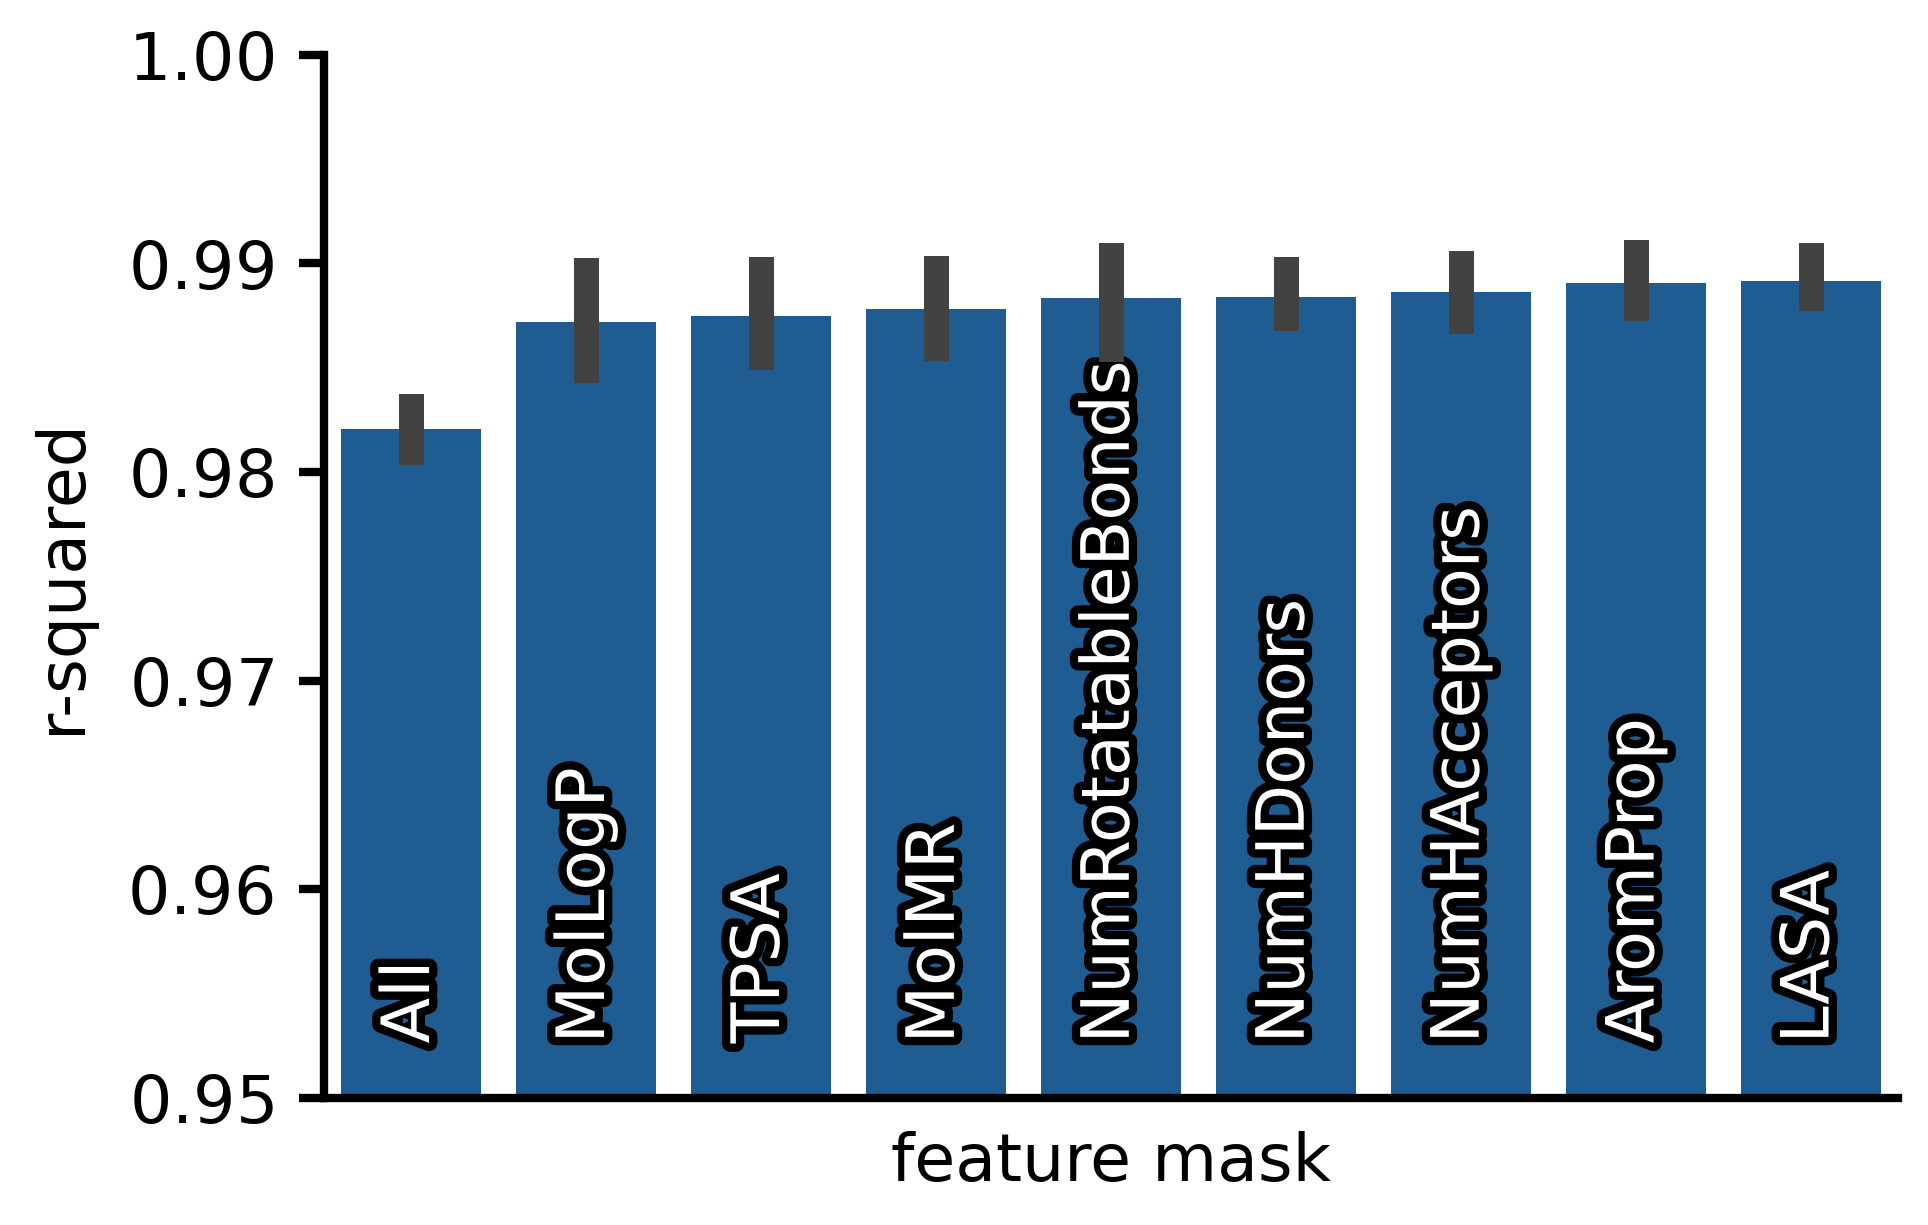

In [1]:
# In this section, I'm just plotting data from results.csv and the mask folder
# https://github.com/gohdavid/ml4me/blob/main/results.csv
# https://github.com/gohdavid/ml4me/tree/main/mask

# In this first part, I'm plotting results from the mask folder
# This is from my masking experiments where I removed RDKit features

from pathlib import Path
import pandas as pd
import seaborn as sns
from package import plot
from matplotlib import pyplot as plt
import matplotlib.patheffects as PathEffects

# Get prediciton files
preds = (Path().cwd() / "mask").glob("testr2_*")
lst = []
for file in preds:
    with file.open("r") as fhd:
        # Read from prediction files
        val = eval(fhd.read())
        # Get R2 only
        r2 = val[0]["batch_averaged_test/r2"]
        # Append this to list in tuple, for df
        lst.append([file.name.split("_")[-2], r2])
# Get df
df = pd.DataFrame(lst)
# Define columns 
df.columns = ["mask", "r2"]
# Define feature mapping
features = ["TPSA", "LASA", "NumRotatableBonds", "NumHDonors", "NumHAcceptors", "MolLogP", "MolMR", "AromProp", "All", "Sig"]
# Make numeric for mapping
df.loc[df["mask"]=="nodescriptor","mask"] = "8"
df.loc[df["mask"]=="sig","mask"] = "9"
# Map features from numeric to name
df["mask"] = df["mask"].apply(lambda x: features[int(x)])
# Get plot order by r2
order = df.groupby("mask").mean()["r2"].sort_values().index

fig, ax = plt.subplots()
sns.barplot(df,x="mask",y="r2",order=order,zorder=-10) # Use seaborn barplot
# Microadjustments
ax.set_ylim(bottom=0.95,top=1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# Labels
ax.set_xlabel("feature mask")
ax.set_ylabel("r-squared")
# Move the xlabels into the bars to save space
for label in ax.get_xticklabels():
    label.set_rotation(90) # make upright
    label.set_verticalalignment('bottom')  # va parameter
    label.set_y(0.1) # translate in y-direction
    label.set_color('white') # make white on blue background
    label.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='black')])
    # add black stroke to emphasise
    label.set_zorder(10)
    # push to the front
# remove ticks in the x-axis
plt.tick_params(
    axis='x',
    which='both',
    bottom=False)
fig.savefig("masking.pdf")

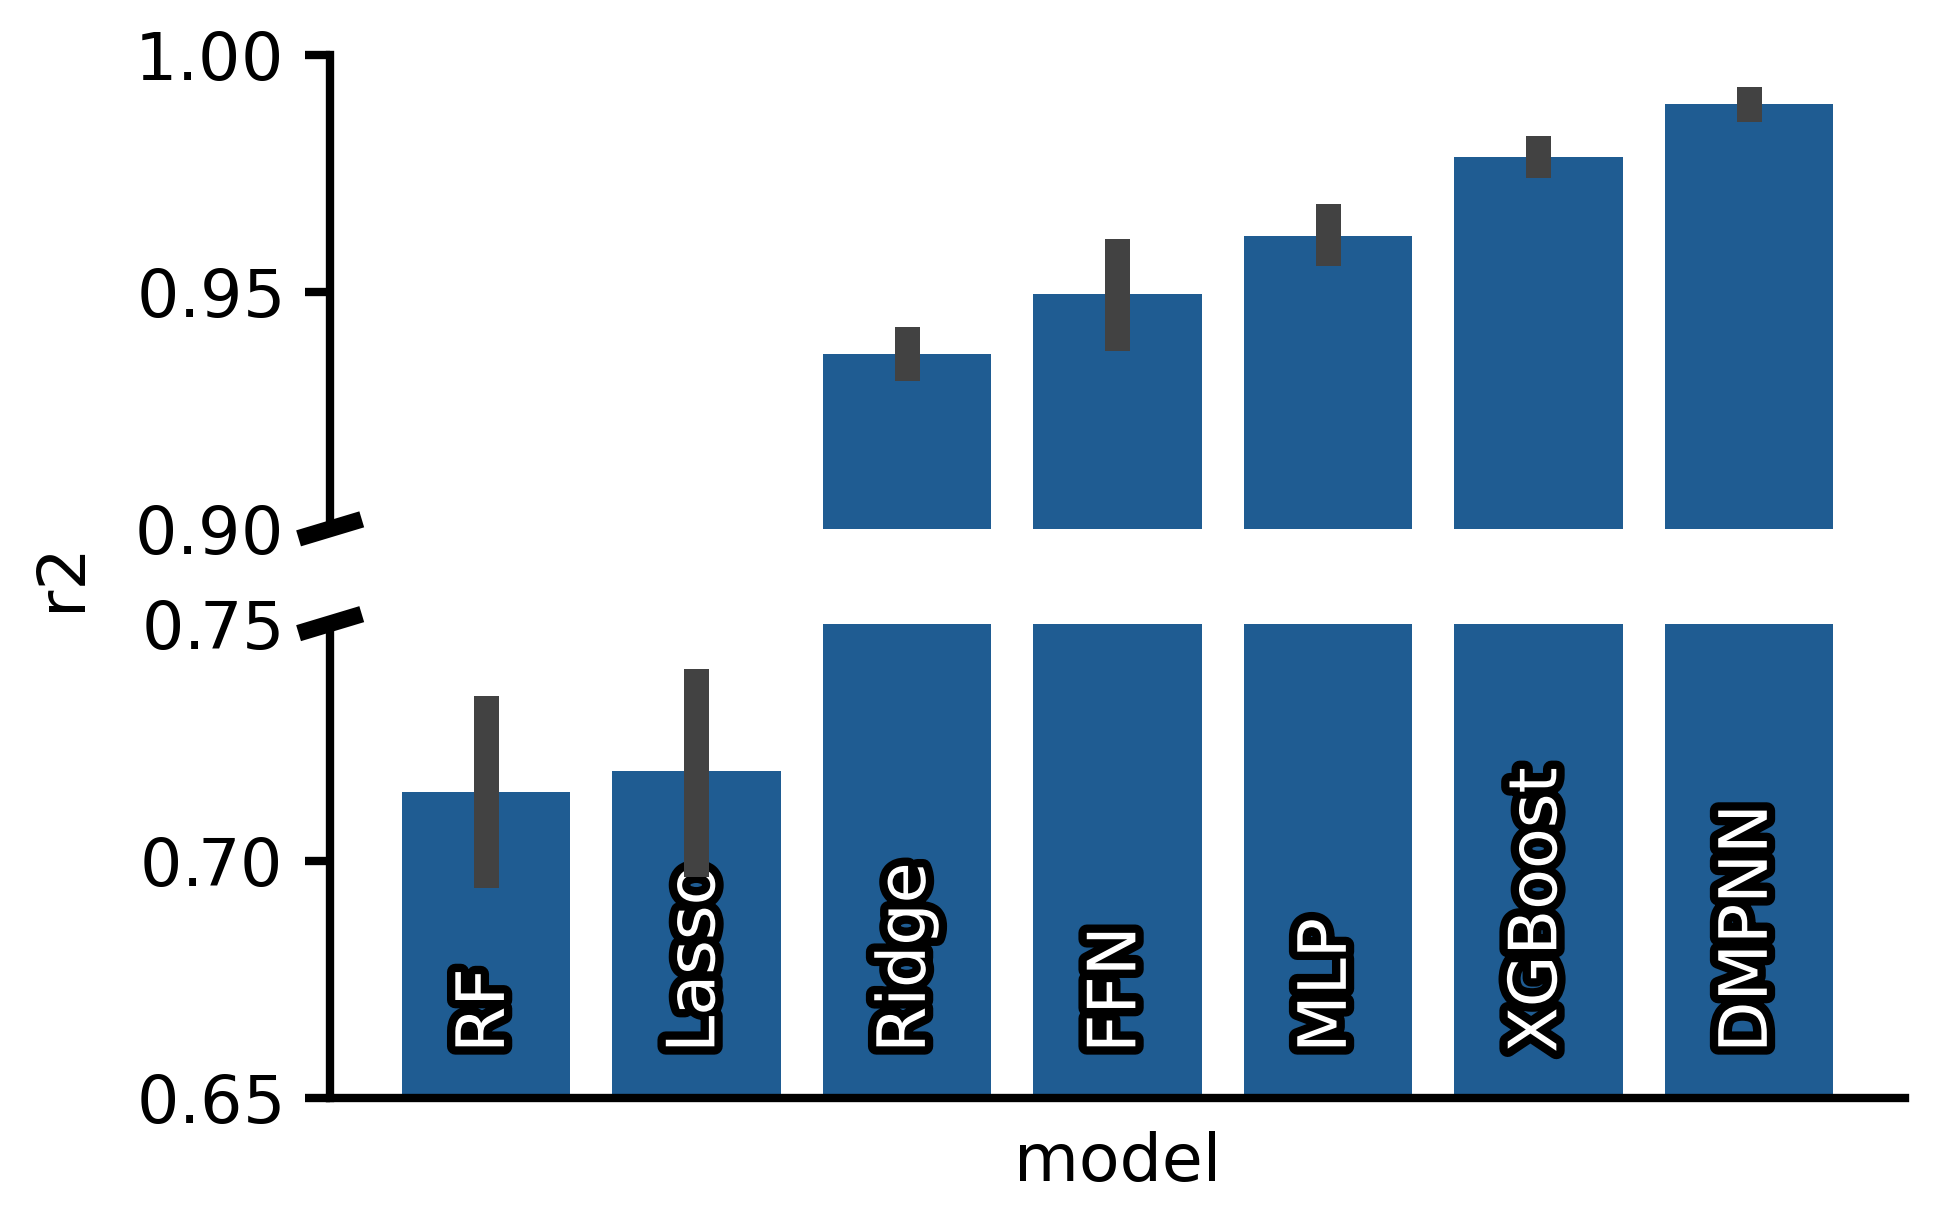

In [2]:
# In this second part, I've collated the model 5-fold CV performances (r-squared) here, and plotted
# it out

# Load the data!
perf_dct = {
# "linear":[-1.95111402e+19, -6.50692697e+16, -6.10952054e+16, -2.22978565e+16, -3.52139824e+18],
"Lasso":[0.71480408, 0.7533171,  0.68961769, 0.73125985, 0.705604  ],
"Ridge":[0.9325229,  0.94038603, 0.93766374, 0.94098614, 0.93326919],
"XGBoost":[0.9787706,  0.97530457, 0.98063007, 0.97697579, 0.98067821],
"RF":[0.69742223 ,0.68523254 ,0.73478339, 0.7359476,  0.7195403 ],
"MLP":[0.95877124, 0.95719349, 0.96224141, 0.96095062, 0.9696648 ],
"FFN":[0.9570232629776001, 0.957734227180481, 0.935830295085907, 0.9366430044174194, 0.9607927203178406],
"DMPNN":[0.990231990814209, 0.9913933873176575, 0.9895720481872559, 0.9875091910362244, 0.9896097779273987]
}

# Turn it into a dataframe!
perf_df = pd.DataFrame(perf_dct)
perf_df[perf_df<0]=0

# Now melt the data so we can plot it with seaborn!
melt_df = perf_df.melt(var_name="model",value_name="r2")
# Get the order by r2
order = melt_df.groupby("model").mean()["r2"].sort_values().index

# Now for some reason I decided to make a split plot, and this is how we do it. Took the code
# from matplotlib documentation.
f, (ax_top, ax_bottom) = plt.subplots(ncols=1, nrows=2, sharex=True, gridspec_kw={'hspace':0.2})
sns.barplot(x="model", y="r2", data=melt_df, ax=ax_top, order=order)
sns.barplot(x="model", y="r2", data=melt_df, ax=ax_bottom, order=order)
ax_top.set_ylim(0.9,1) # Keep the top and bottom limits the same to not misrepresent the scales!
ax_bottom.set_ylim(0.65,0.75)

# Despine the bottom of the top
sns.despine(ax=ax_bottom)
sns.despine(ax=ax_top, bottom=True)

# Now remove the ticsk on the top plot, and other things like the label
ax_top.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# This is modifying the two lines denoting the split on the y-axis
ax = ax_top
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal

ax2 = ax_bottom
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

# Here, I'm adjusting the xlabels similarly to above to put them inside the bars
for label in ax_bottom.get_xticklabels():
    label.set_rotation(90)
    label.set_verticalalignment('bottom')  # Center alignment vertically
    label.set_y(0.2)
    label.set_color('white')
    label.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='black')])
    label.set_zorder(10)

# Here, I'm removing the ticks that overlap with the split markers. It looked ugly.
ax.yaxis.get_major_ticks()[0].tick1line.set_markersize(0)
ax2.yaxis.get_major_ticks()[-1].tick1line.set_markersize(0)

# Remofe the xticsm because it's pointless now that the labels are inside the abr
plt.tick_params(
    axis='x',
    which='both',
    bottom=False)

# Prevent double y-label
ax2.set_ylabel("")
# Translatehte y-label
ax.yaxis.set_label_coords(-0.15,-0.1)
f.savefig("model.pdf")

# Ensemble of 20 classifiers

To do the ensemble, just run the exact same D-MPNN tuned model on 20 separate scripts, so that it uses differnet random splits. Because we are mainly concerned with performance at this point and we have finished tuning, we don't need a validation set. We'll use a 90/10 test train split because we still need to get some understanding if the model works well and to get some generalization by subsampling the data.

The prediction on the Kaggle dataset are then aggregated and averaged to give our ensemble prediction in Kaggle. Our ensemble prediction is one of the best performing one, and one of the one we submitted for final evaluation.

The ensemble code is here https://github.com/gohdavid/ml4me/blob/main/scripts/ensemble.py

The ensemble results are here https://github.com/gohdavid/ml4me/tree/main/ensemble2

The only change in the ensemble code is this:

```
split_type="random"
split = (0.9, 0.01, 0.09)
```

We still need 0.01 for the validation since Chemprop doesn't allow zero validation, and I didn't want to define my own splitting function. It's negligible.

The other difference is that we're training this 20 times and letting the randomness give differnet models and predictions. This is kind of like bagging (boostrap aggregating).